<a href="https://colab.research.google.com/github/maetthil/NASASpaceApps/blob/main/Read_CDF_Files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install cdflib
# !pip install spacepy
!pip install pyspedas
!pip install matplotlib

In [6]:
import cdflib 
import sys
import os
import requests
import pytz
import datetime
import pandas as pd
from bs4 import BeautifulSoup as bs
from tqdm.notebook import tqdm


import pyspedas
from pytplot import tplot
import pytplot

In [7]:
def download_bwt_file(year='2022'):
    url = f'https://cdaweb.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/{year}/'
    content = requests.get(url).content
    DATA_FOLDER = 'dataset/'
    if not os.path.exists(DATA_FOLDER):
        os.mkdir(DATA_FOLDER)
    links = bs(content).findAll('a', href=True)
    print (f'Baixando arquivos de dados de {year}')
    for link in tqdm(links):
        filename = link['href']
        if filename.find('.cdf') < 0:
            continue
        response = requests.get(f'{url}{filename}')
        with open(f'{DATA_FOLDER}{filename}', 'wb') as f:
            f.write(response.content)

In [8]:
download_bwt_file()

Baixando arquivos de dados de 2022


  0%|          | 0/264 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [9]:
data_cdf = cdflib.CDF("/content/dataset/wi_h2_mfi_20220104_v04.cdf")

In [14]:
print(data_cdf)

In [39]:
# Verifica quais são as variaveis dentro do arquivo
data_info = data_cdf.cdf_info()
# data_info

In [22]:
# Nesse caso queremos o campo magnético, B. Eles oferem nas coordenadas GSM, e GSE
# Acredito que para essa aplicação pode ser a GSM mesmo nesse momento

magnetic_field_gsm = data_cdf.varget("BGSM")
# São tres colunas, x, y e z
magnetic_field_gsm.shape

(937849, 3)

In [34]:
mag_field_dataframe = pd.DataFrame(magnetic_field_gsm, columns=["Bx_GSM", "Gy_GSM", "Bz_GSM"])

time = data_cdf.varget("Epoch")
mag_field_dataframe["Epoch"] = time

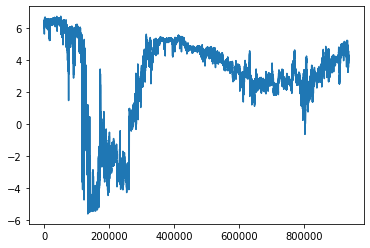

In [38]:
mag_field_dataframe["Gy_GSM"].plot()

Outra forma de Ler os arquivos (Acho mais Facil), é utilizando o modulo pyspedas, ele facilita o download e a leitura dos dados.

# Magnetometer (MAG)

In [3]:
# usando o pyspedas
mag_vars = pyspedas.dscovr.mag(trange=['2018-11-5', '2018-11-6'])

  ErfaWarning)



In [4]:
mag_vars

['dsc_h0_mag_B1F1',
 'dsc_h0_mag_B1SDF1',
 'dsc_h0_mag_B1GSE',
 'dsc_h0_mag_B1SDGSE',
 'dsc_h0_mag_B1RTN',
 'dsc_h0_mag_B1SDRTN']

In [7]:
# nesse caso presisamos algums passoa a mais para extrair as componentes
# Elas sao salvas no formato do pyspedas e para o pytplot

quants_Bgse = pytplot.data_quants['dsc_h0_mag_B1GSE']
quants_Bgse

In [10]:
# bx, by, bz
b_gsm = quants_Bgse.values
time = quants_Bgse.coords['time'].values
time_dt_b = [datetime.datetime.fromtimestamp(i, pytz.timezone("UTC")) for i in time]

In [11]:
dataframe_gse = pd.DataFrame(b_gsm, columns=["Bx_GSM", "Gy_GSM", "Bz_GSM"], index = time_dt_b)
dataframe_gse.head()

,Bx_GSM,Gy_GSM,Bz_GSM
2018-11-05 00:00:00.500000+00:00,1.194376,3.056361,7.773695
2018-11-05 00:00:01.500000+00:00,1.006090,2.963387,7.727819
2018-11-05 00:00:02.500000+00:00,1.565910,2.421731,7.809438
2018-11-05 00:00:03.500000+00:00,1.852083,2.311245,7.771448
2018-11-05 00:00:04.500000+00:00,1.205482,2.037003,7.789549


# Faraday Cup (FC)

In [14]:
pytplot.del_data()
fc_vars = pyspedas.dscovr.fc(trange=['2018-11-5', '2018-11-6'])

In [16]:
quants_Vgse = pytplot.data_quants['dsc_h1_fc_V_GSE']
quants_thermalSpeed = pytplot.data_quants['dsc_h1_fc_THERMAL_SPD']
quants_Np = pytplot.data_quants['dsc_h1_fc_Np']
quants_thermalTemp = pytplot.data_quants['dsc_h1_fc_THERMAL_TEMP']

time_fc = quants_Vgse.coords['time'].values
time_fc_dt = [datetime.datetime.fromtimestamp(i, pytz.timezone("UTC")) for i in time_fc]
# tplot(['dsc_h1_fc_V_GSE', 'dsc_h1_fc_THERMAL_SPD', 'dsc_h1_fc_Np', 'dsc_h1_fc_THERMAL_TEMP'])

In [19]:
dataframe_fc = pd.DataFrame({"dsc_h1_fc_Vx_GSE":quants_Vgse[:,0], 
                             "dsc_h1_fc_Vy_GSE":quants_Vgse[:,1],
                             "dsc_h1_fc_Vz_GSE":quants_Vgse[:,2],
                             "dsc_h1_fc_THERMAL_SPD":quants_thermalSpeed.values, 
                             "dsc_h1_fc_Np":quants_Np.values, 
                             'dsc_h1_fc_THERMAL_TEMP':quants_thermalTemp.values}, index = time_fc_dt)
dataframe_fc.head()

,dsc_h1_fc_Vx_GSE,dsc_h1_fc_Vy_GSE,dsc_h1_fc_Vz_GSE,dsc_h1_fc_THERMAL_SPD,dsc_h1_fc_Np,dsc_h1_fc_THERMAL_TEMP
2018-11-05 00:00:00+00:00,-473.958740,11.917868,21.795387,68.390205,7.510447,283316.81250
2018-11-05 00:01:01+00:00,-476.043488,10.830706,19.726019,68.216896,7.552746,281882.71875
2018-11-05 00:02:01+00:00,-476.112701,1.879187,18.163383,67.262222,7.682232,274048.18750
2018-11-05 00:02:59+00:00,-476.207031,9.003065,22.759775,67.437187,7.538317,275475.75000
2018-11-05 00:04:00+00:00,-474.836334,12.154074,26.012655,67.979271,7.299348,279922.34375


In [18]:
quants_Vgse.values

array([[-473.95874  ,   11.917868 ,   21.795387 ],
       [-476.0435   ,   10.830706 ,   19.726019 ],
       [-476.1127   ,    1.8791875,   18.163383 ],
       ...,
       [-519.91223  ,   24.913795 ,   97.32132  ],
       [-520.6441   ,   24.327417 ,   98.12596  ],
       [-521.3288   ,   26.78499  ,   99.64456  ]], dtype=float32)